# DNO Population Data

Calculate the population of each DNO zone as a percentage of the GB total.

Data sources:

* DNO license area shapefiles (2020): https://www.neso.energy/data-portal/gis-boundaries-gb-dno-license-areas 
* Population data (2019): https://data.humdata.org/dataset/united-kingdom-high-resolution-population-density-maps-demographic-estimates 

<div class="alert alert-info">
<b>Author:</b> James Fallon 2025-05-29
</div>

## Module imports and setup

In [1]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import geopandas as gpd
import shapely
import rasterio

In [2]:
# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt

In [3]:
# paths to shapefiles and raster files
shapefile_paths = {
    "DNO": Path("/data/users/james.fallon/shapes_and_masks/DNO/DNO_License_Areas_20240503_latlon.shp"),
    "Population_Weights": Path("/data/users/james.fallon/shapes_and_masks/Weights/population_gbr_20190_v1_era5grid.tif")
}

## Read Data

### DNO shapefiles

In [4]:
# read NESO's DNO shapefile
dno_shapes = gpd.read_file(shapefile_paths["DNO"])
dno_shapes

,ID,Name,DNO,Area,DNO_Full,geometry
0,10,_A,UKPN,East England,UK Power Networks,"MULTIPOLYGON (((0.875 51.513, 0.877 51.513, 0...."
1,11,_B,NGED,East Midlands,National Grid Electricity Distribution,"POLYGON ((0.267 52.812, 0.267 52.812, 0.264 52..."
2,12,_C,UKPN,London,UK Power Networks,"POLYGON ((-0.244 51.488, -0.245 51.489, -0.246..."
3,13,_D,SPEN,"North Wales, Merseyside and Cheshire",SP Energy Networks,"MULTIPOLYGON (((-4.255 53.388, -4.256 53.388, ..."
4,14,_E,NGED,West Midlands,National Grid Electricity Distribution,"POLYGON ((-1.959 53.217, -1.957 53.214, -1.956..."
5,15,_F,NPG,North East England,Northern Powergrid,"MULTIPOLYGON (((-1.598 55.627, -1.599 55.627, ..."
6,16,_G,ENWL,North West England,Electricity North West,"POLYGON ((-2.662 55.146, -2.657 55.136, -2.651..."
7,17,_P,SSEN,North Scotland,Scottish and Southern Electricity Networks,"MULTIPOLYGON (((-5.116 55.241, -5.119 55.241, ..."
8,19,_J,UKPN,South East England,UK Power Networks,"POLYGON ((0.566 51.489, 0.573 51.488, 0.579 51..."
9,21,_K,NGED,South Wales,National Grid Electricity Distribution,"MULTIPOLYGON (((-3.114 51.376, -3.115 51.375, ..."


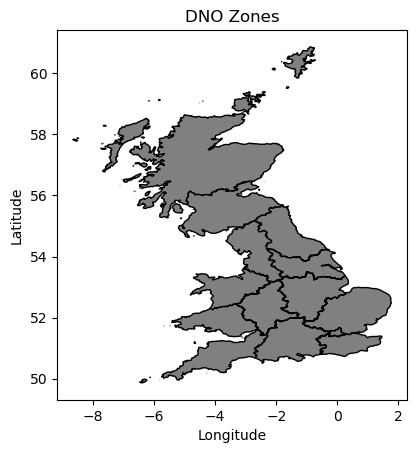

In [5]:
dno_shapes.plot(color="grey", edgecolor="black", linewidth=1)
plt.title("DNO Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show();

### Population rasterdata

In [6]:
# define lats and lons coords
# (matches ERA5ATLAS grid)
lats = np.arange(62, 46.99, -0.1)
lons = np.arange(-10, 3.01, 0.1)
lon2d, lat2d = np.meshgrid(lons, lats)

In [7]:
# Weight grid cells by actual area (cosine wieghting for latitude)
cosine_weights = np.cos(np.radians(lat2d))

In [8]:
# read the population weights raster and apply cosine weighting
with rasterio.open(shapefile_paths["Population_Weights"]) as src:
    population_data = src.read(1)
    population_metadata = src.meta

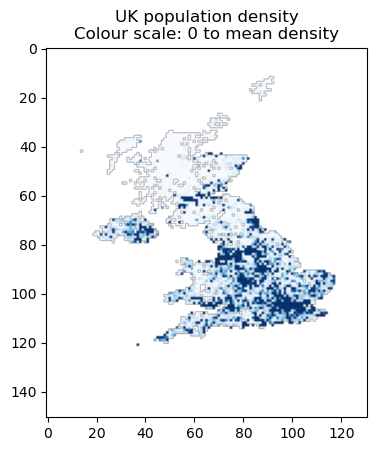

In [9]:
plt.imshow(population_data, cmap="Blues", vmin=0, vmax=288)
plt.title("UK population density\nColour scale: 0 to mean density")
plt.colorbar;

In [10]:
population_data_ma = np.ma.MaskedArray(population_data, mask=np.isnan(population_data))
(~np.isnan(population_data)).sum()

np.int64(3379)

In [11]:
# Validation - get the mean population density and compare to known value
print(f"GB population density mean: {np.nanmean(population_data):.2f}")
print(f"GB population density mean (cosine weighted): {np.ma.average(population_data_ma, weights=cosine_weights):.2f}")
print("Our world in data value (for UK): 287.5 km^-2")

GB population density mean: 593.36
GB population density mean (cosine weighted): 616.59
Our world in data value (for UK): 287.5 km^-2


## Population Calculations

In [12]:
# Craete gridded population data with mask applied for each DNO zone
population_masked = dict()

for region in dno_shapes.Name:
    # Create a mask for the DNO region
    dno_shape = dno_shapes.query(f"Name == '{region}'").reset_index().loc[0]
    dno_mask = ~shapely.contains_xy(dno_shape.geometry, lon2d, lat2d)

    # Mask the population data using the DNO mask
    population_masked[region] = np.ma.array(population_data_ma, mask=dno_mask)

In [13]:
# Get the total population density sum of GB
total_population = sum(np.nansum(data*cosine_weights) for data in population_masked.values())
print(f"Total population {total_population:.2f} (units are population density)")

Total population 1155193.07 (units are population density)


In [14]:
# Print the percentage of the total population contained within each DNO region
for region, data in population_masked.items():
    p = data*cosine_weights/total_population * 100
    print(region, f"{np.nansum(p):.2f}%")

_A 13.31%
_B 10.01%
_C 7.54%
_D 4.35%
_E 9.90%
_F 3.93%
_G 7.24%
_P 1.65%
_J 8.67%
_K 5.03%
_L 4.85%
_M 6.90%
_N 5.00%
_H 11.62%
